In [127]:
import pandas as pd
import sys
import numpy
import plotly.express as px
import plotly.figure_factory as ff
import seaborn as sns
import optuna

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression

# Импорт, анализ и предобработка данных

Импортируем датасет. Сразу же посмотрим на какие-нибудь строки. 

In [128]:
DF = pd.read_csv('spam_or_not_spam.csv')

DF.head()

,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0


Посмотрим на базовую информацию о "качестве" данных.

In [129]:
print(f'Количество строк в датасете: {len(DF)}')
print(f'Количество нулевых признаков: {sum(DF.email.isnull())}')
print(f'Количество дубликатов: {sum(DF.duplicated())}')

Количество строк в датасете: 3000
Количество нулевых признаков: 1
Количество дубликатов: 127


Пустой признак меня убивает - даже захотелось отдельно на него посмотреть, потому что это чудо какое-то. Давайте его выведем.

In [130]:
DF[DF.email.isnull()]

,email,label
2966,NaN,1


Почистим датасет от пустых строк и дубликатов.

In [131]:
DF = DF.dropna()
DF = DF.drop_duplicates()

print(f'Количество строк в датасете: {len(DF)}')

Количество строк в датасете: 2872


Вероятно, стоит вывести информацию о сбалансированности классов - как минимум это поможет нам выбрать лучшую "целевую метрику".

<AxesSubplot:xlabel='label', ylabel='Count'>

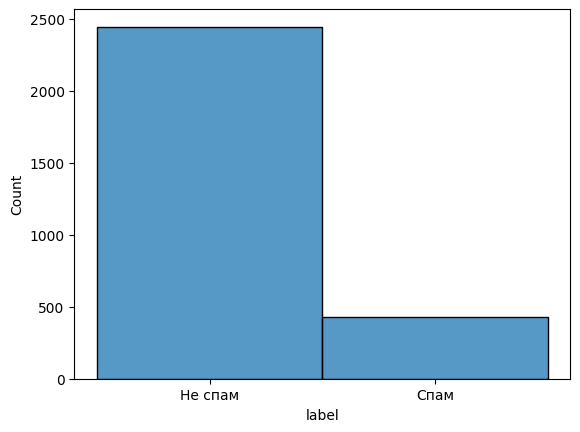

In [132]:
classes_map = {0: "Не спам", 1: "Спам"}
sns.histplot(DF.label.map(classes_map))

Датасет не очень сбалансирован. Конечно, можно поиграться с синтетическими данными - но так как мы работаем с текстом это будет как минимум сложно, если мы не хотим испортить качество данных.

В таком случае, в качестве метрики для работы с датасетом можно использовать как **f1_score**, так и **ROC AUC**. 

Отдельно отметим, что при работе с **f1_score** желательно так же строить **confusion matrix** и считать **precision и recall**, чтобы подобрать подходящий задаче **threshold**.

Разобьем данные на **train** и **test** выборки.

In [133]:
X_train, X_test, y_train, y_test = train_test_split(DF.email, DF.label, test_size=0.22, random_state=42, stratify = DF.label)

# Векторизация данных

Интересный нюанс: в будущем мы будем обучать в том числе и линейные модели. Я уж думал использовать standart scaler для нормализации данных, но на просторах интернета я прочитал, что все результаты векторайзеров можно и не нормализировать.

## Сount Vectorizer

In [134]:
vectorizer = CountVectorizer()
vectorizer.fit(DF.email)
X_cv = vectorizer.transform(X_train)
X_cv_test = vectorizer.transform(X_test)

In [135]:
numpy.set_printoptions(threshold=sys.maxsize)
print(vectorizer.get_feature_names_out())

['__' '___' '____' '_____' '______' '_______' '________' '_________'
 '__________' '______________' '_______________' '________________'
 '___________________' '____________________' '_______________________'
 '________________________' '_________________________'
 '__________________________' '______________________________'
 '_______________________________' '________________________________'
 '_________________________________' '___________________________________'
 '______________________________________'
 '__________________________________________'
 '_____________________________________________'
 '______________________________________________'
 '_______________________________________________'
 '________________________________________________'
 '_________________________________________________'
 '__________________________________________________'
 '___________________________________________________'
 '____________________________________________________'
 '_________________

In [136]:
X_cv

<2240x34116 sparse matrix of type '<class 'numpy.int64'>'
	with 262980 stored elements in Compressed Sparse Row format>

## TF IDF vectirizer

In [137]:
vectorizer = TfidfVectorizer()
vectorizer.fit(DF.email)
X_tf = vectorizer.transform(X_train)
X_tf_test = vectorizer.transform(X_test)

In [138]:
numpy.set_printoptions(threshold=sys.maxsize)
print(vectorizer.get_feature_names_out())

['__' '___' '____' '_____' '______' '_______' '________' '_________'
 '__________' '______________' '_______________' '________________'
 '___________________' '____________________' '_______________________'
 '________________________' '_________________________'
 '__________________________' '______________________________'
 '_______________________________' '________________________________'
 '_________________________________' '___________________________________'
 '______________________________________'
 '__________________________________________'
 '_____________________________________________'
 '______________________________________________'
 '_______________________________________________'
 '________________________________________________'
 '_________________________________________________'
 '__________________________________________________'
 '___________________________________________________'
 '____________________________________________________'
 '_________________

In [139]:
X_tf

<2240x34116 sparse matrix of type '<class 'numpy.float64'>'
	with 262980 stored elements in Compressed Sparse Row format>

Очевидно, что в исходных данных много мусора, который мы бы легко убрали лемматизацией и базовой предобработкой текста. Из-за этого и сама матрица получается ну уж очень большой. 

Но есть небольшие опасения - ведь задачей является детекция спама. И что, как не всякий разный мусор, помогает нам детектировать спам?

## МУДРОЕ ДРЕВО

In [140]:
clf_tree = DecisionTreeClassifier(random_state=42)

params = {
'criterion': ['gini', 'entropy'],
'max_depth': range(2, 20, 1),
'min_samples_leaf': range (1, 5, 1),
'ccp_alpha': [0.1, 0.01, 0.001]
}

model = GridSearchCV(estimator=clf_tree, scoring = 'roc_auc',
             param_grid=params, cv = 3)

### TF IDF

In [141]:
model.fit(X_tf, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'ccp_alpha': [0.1, 0.01, 0.001],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': range(2, 20),
                         'min_samples_leaf': range(1, 5)},
             scoring='roc_auc')

In [142]:
tree_TF = model.best_estimator_
tree_TF

DecisionTreeClassifier(ccp_alpha=0.001, max_depth=12, min_samples_leaf=4,
                       random_state=42)

In [143]:
print (f'AUC лучшей модели на кросс валидации: {max(model.cv_results_["mean_test_score"])}')

AUC лучшей модели на кросс валидации: 0.92791038698779


### Count Vectors

In [144]:
model.fit(X_cv, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'ccp_alpha': [0.1, 0.01, 0.001],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': range(2, 20),
                         'min_samples_leaf': range(1, 5)},
             scoring='roc_auc')

In [145]:
tree_CV = model.best_estimator_
tree_CV

DecisionTreeClassifier(ccp_alpha=0.001, criterion='entropy', max_depth=12,
                       min_samples_leaf=3, random_state=42)

In [146]:
print (f'AUC лучшей модели на кросс валидации: {max(model.cv_results_["mean_test_score"])}')

AUC лучшей модели на кросс валидации: 0.9557607377099281


## ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ

In [147]:
clf = LogisticRegression(random_state=42, solver='liblinear')

params = {'penalty': ['l1','l2'], 
               'C': [0.001,0.01,0.1,1,10, 100]}

model = GridSearchCV(estimator=clf, scoring = 'roc_auc',
             param_grid=params, cv = 3)

### TF IDF

In [148]:
model.fit(X_tf, y_train)

GridSearchCV(cv=3,
             estimator=LogisticRegression(random_state=42, solver='liblinear'),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2']},
             scoring='roc_auc')

In [149]:
logit_TF = model.best_estimator_
logit_TF

LogisticRegression(C=10, random_state=42, solver='liblinear')

In [150]:
print (f'AUC лучшей модели на кросс валидации: {max(model.cv_results_["mean_test_score"])}')

AUC лучшей модели на кросс валидации: 0.9958273308221309


### Count Vectors

In [151]:
model.fit(X_cv, y_train)

c:\users\vsevo\pycharmprojects\dls_contest\venv\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
c:\users\vsevo\pycharmprojects\dls_contest\venv\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
c:\users\vsevo\pycharmprojects\dls_contest\venv\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
c:\users\vsevo\pycharmprojects\dls_contest\venv\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


GridSearchCV(cv=3,
             estimator=LogisticRegression(random_state=42, solver='liblinear'),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2']},
             scoring='roc_auc')

In [152]:
logit_CV = model.best_estimator_
logit_CV

LogisticRegression(C=1, random_state=42, solver='liblinear')

In [153]:
print (f'AUC лучшей модели на кросс валидации: {max(model.cv_results_["mean_test_score"])}')

AUC лучшей модели на кросс валидации: 0.9894426516845177


## НАИВНЫЙ БАЙЕС

In [189]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()

params = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4]}

model = GridSearchCV(estimator=clf, scoring = 'roc_auc',
             param_grid=params, cv = 3)

### TF IDF

In [190]:
model.fit(X_tf.toarray(), y_train)

GridSearchCV(cv=3, estimator=GaussianNB(),
             param_grid={'var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05,
                                           0.0001]},
             scoring='roc_auc')

In [191]:
bayes_TF = model.best_estimator_
bayes_TF

GaussianNB(var_smoothing=0.0001)

In [192]:
print (f'AUC лучшей модели на кросс валидации: {max(model.cv_results_["mean_test_score"])}')

AUC лучшей модели на кросс валидации: 0.9157827267172091


### Count Vectors

In [193]:
model.fit(X_cv.toarray(), y_train)

GridSearchCV(cv=3, estimator=GaussianNB(),
             param_grid={'var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05,
                                           0.0001]},
             scoring='roc_auc')

In [194]:
bayes_CV = model.best_estimator_
bayes_CV

GaussianNB(var_smoothing=1e-05)

In [195]:
print (f'AUC лучшей модели на кросс валидации: {max(model.cv_results_["mean_test_score"])}')

AUC лучшей модели на кросс валидации: 0.8855050415145498


## ВЕЛИКИЙ И УЖАСНЫЙ КЭТБУСТ ИЗ КОРОБКИ

все таки в него лучше не засовывать матрицу с 3000 признаков, так что вспомним про SVD

## TF-IDF

In [161]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components = 1000, random_state = 42)
svd.fit(X_tf)

var_explained = svd.explained_variance_ratio_.sum()
var_explained

0.7985959831589173

In [162]:
X_tf_svd = svd.transform(X_tf)
X_tf_svd_test = svd.transform(X_tf_test)

In [163]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(eval_metric = 'AUC')
model.fit(X_tf_svd, y_train)

Learning rate set to 0.014538
0:	total: 204ms	remaining: 3m 23s
1:	total: 308ms	remaining: 2m 33s
2:	total: 413ms	remaining: 2m 17s
3:	total: 521ms	remaining: 2m 9s
4:	total: 621ms	remaining: 2m 3s
5:	total: 724ms	remaining: 2m
6:	total: 823ms	remaining: 1m 56s
7:	total: 925ms	remaining: 1m 54s
8:	total: 1.02s	remaining: 1m 52s
9:	total: 1.13s	remaining: 1m 51s
10:	total: 1.23s	remaining: 1m 50s
11:	total: 1.33s	remaining: 1m 49s
12:	total: 1.43s	remaining: 1m 48s
13:	total: 1.53s	remaining: 1m 47s
14:	total: 1.63s	remaining: 1m 46s
15:	total: 1.73s	remaining: 1m 46s
16:	total: 1.83s	remaining: 1m 45s
17:	total: 1.93s	remaining: 1m 45s
18:	total: 2.04s	remaining: 1m 45s
19:	total: 2.13s	remaining: 1m 44s
20:	total: 2.24s	remaining: 1m 44s
21:	total: 2.34s	remaining: 1m 44s
22:	total: 2.44s	remaining: 1m 43s
23:	total: 2.54s	remaining: 1m 43s
24:	total: 2.64s	remaining: 1m 43s
25:	total: 2.74s	remaining: 1m 42s
26:	total: 2.84s	remaining: 1m 42s
27:	total: 2.94s	remaining: 1m 42s
28:	to

Модель обучается ужас как долго, так что тюнить её на столь большом датасете это очень плохая идея

In [164]:
from sklearn.metrics import roc_auc_score

CatBoost_TF = model

roc_auc_score (y_test, model.predict_proba(X_tf_svd_test)[:, 1])

0.9932571383374199

## Count Vectors

In [165]:
svd = TruncatedSVD(n_components = 8, random_state = 42)
svd.fit(X_cv)

var_explained = svd.explained_variance_ratio_.sum()
var_explained

0.924772031983924

мир полон чудес и поводов для удивления

In [166]:
X_cv_svd = svd.transform(X_cv)
X_cv_svd_test = svd.transform(X_cv_test)

In [167]:
model = CatBoostClassifier(eval_metric = 'AUC')
model.fit(X_cv_svd, y_train)

Learning rate set to 0.014538
0:	total: 3.94ms	remaining: 3.93s
1:	total: 7.57ms	remaining: 3.77s
2:	total: 13.3ms	remaining: 4.41s
3:	total: 16.9ms	remaining: 4.21s
4:	total: 20.3ms	remaining: 4.04s
5:	total: 23.7ms	remaining: 3.92s
6:	total: 28.6ms	remaining: 4.06s
7:	total: 31.9ms	remaining: 3.96s
8:	total: 35.4ms	remaining: 3.9s
9:	total: 38.8ms	remaining: 3.84s
10:	total: 43.9ms	remaining: 3.95s
11:	total: 47.4ms	remaining: 3.9s
12:	total: 50.8ms	remaining: 3.86s
13:	total: 53.9ms	remaining: 3.79s
14:	total: 57.8ms	remaining: 3.79s
15:	total: 61.5ms	remaining: 3.78s
16:	total: 64.6ms	remaining: 3.73s
17:	total: 67.9ms	remaining: 3.71s
18:	total: 71ms	remaining: 3.66s
19:	total: 76.1ms	remaining: 3.73s
20:	total: 79.5ms	remaining: 3.71s
21:	total: 82.4ms	remaining: 3.66s
22:	total: 85.3ms	remaining: 3.63s
23:	total: 88.8ms	remaining: 3.61s
24:	total: 92.9ms	remaining: 3.62s
25:	total: 95.9ms	remaining: 3.59s
26:	total: 98.7ms	remaining: 3.56s
27:	total: 101ms	remaining: 3.52s
28:	t

In [168]:
CatBoost_CV = model

roc_auc_score (y_test, model.predict_proba(X_cv_svd_test)[:, 1])

0.9622320651744048

со столь высокой скоростью обучения можно даже и потюнить параметры, например, с помощью оптуны

In [169]:
def cb_objective_clf(trial):
    
    param = {
        'random_state': 13,
        'learning_rate': trial.suggest_float("learning_rate", 0.0001, 0.2),
        'depth': trial.suggest_int("depth", 2, 15),
        'min_data_in_leaf': trial.suggest_int("min_data_in_leaf", 1, 12)
    }
        
    model = CatBoostClassifier(**param)
    model.fit(X_cv_svd, y_train, verbose = 0)
    auc = roc_auc_score (y_test, model.predict_proba(X_cv_svd_test)[:, 1])
    return auc

кажется я забыл зафиксировать random state оптуны, но мне правда очень лень снова ставить ноутбук все это считать... все равно там разница будет не критической

In [170]:
study = optuna.create_study(direction="maximize")
study.optimize(cb_objective_clf, n_trials=20)

[I 2023-10-15 15:51:07,148] A new study created in memory with name: no-name-ea2dfaf2-089b-42ec-b86e-603d34561e83
[I 2023-10-15 15:51:11,115] Trial 0 finished with value: 0.9624693506288065 and parameters: {'learning_rate': 0.1816100490597189, 'depth': 7, 'min_data_in_leaf': 4}. Best is trial 0 with value: 0.9624693506288065.
[I 2023-10-15 15:51:13,214] Trial 1 finished with value: 0.961203828205331 and parameters: {'learning_rate': 0.13721777406644406, 'depth': 3, 'min_data_in_leaf': 9}. Best is trial 0 with value: 0.9624693506288065.
[I 2023-10-15 15:51:17,801] Trial 2 finished with value: 0.963715099264415 and parameters: {'learning_rate': 0.10833521960432312, 'depth': 7, 'min_data_in_leaf': 5}. Best is trial 2 with value: 0.963715099264415.
[I 2023-10-15 15:51:19,665] Trial 3 finished with value: 0.9622320651744048 and parameters: {'learning_rate': 0.18782292205535364, 'depth': 3, 'min_data_in_leaf': 2}. Best is trial 2 with value: 0.963715099264415.
[I 2023-10-15 15:54:11,642] Tri

KeyboardInterrupt: 

In [200]:
CatBoost_CV = CatBoostClassifier(**study.best_trial.params)
CatBoost_CV.fit(X_cv_svd, y_train, verbose = 0)

# Сравнение моделей

Давайте вспомним все модели, которые мы обучили. Построим для каждой из них Confusion Matrix посчитаем precision, recall и f1_score. После чего поймем, какая из моделей лучше для какой из задач. 

Отдельно отметим, что предварительно мы будем обучать модели на всей train выборке, а валидировать на отложенной.

In [176]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def print_res (model, dataset_train, dataset_test):
    model.fit(dataset_train, y_train)
    print (model)
    pred = model.predict(dataset_test)
    print ()
    print (classification_report(y_test, pred))
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, pred), display_labels=model.classes_)
    disp.plot()

## TF-IDF

DecisionTreeClassifier(ccp_alpha=0.001, max_depth=12, min_samples_leaf=4,
                       random_state=42)

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       538
           1       0.86      0.83      0.84        94

    accuracy                           0.95       632
   macro avg       0.91      0.90      0.91       632
weighted avg       0.95      0.95      0.95       632



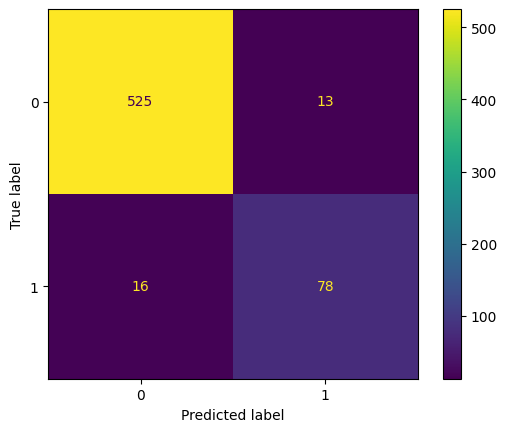

In [177]:
print_res(tree_TF, X_tf, X_tf_test)

LogisticRegression(C=10, random_state=42, solver='liblinear')

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       538
           1       0.99      0.87      0.93        94

    accuracy                           0.98       632
   macro avg       0.98      0.94      0.96       632
weighted avg       0.98      0.98      0.98       632



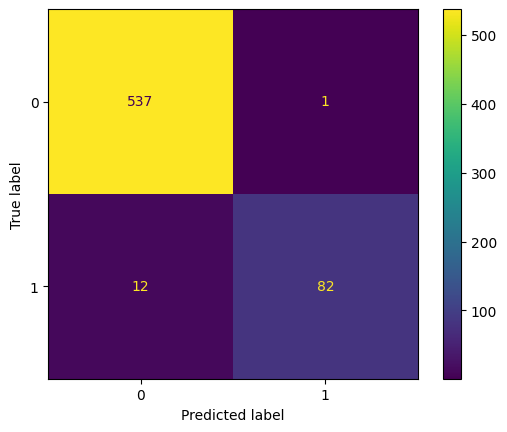

In [178]:
print_res(logit_TF, X_tf, X_tf_test)

GaussianNB(var_smoothing=0.0001)

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       538
           1       0.86      0.91      0.89        94

    accuracy                           0.97       632
   macro avg       0.92      0.94      0.93       632
weighted avg       0.97      0.97      0.97       632



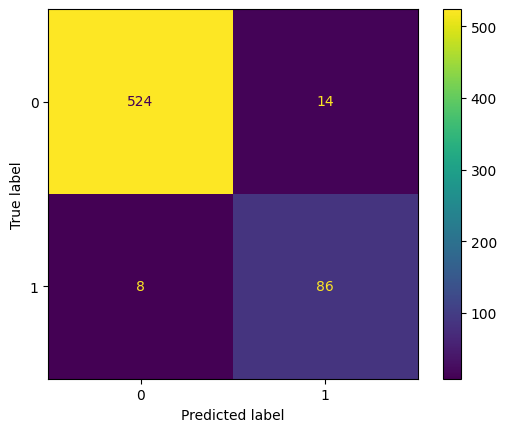

In [197]:
print_res(bayes_TF, X_tf.toarray(), X_tf_test.toarray())


              precision    recall  f1-score   support

           0       0.98      1.00      0.99       538
           1       0.99      0.89      0.94        94

    accuracy                           0.98       632
   macro avg       0.98      0.95      0.96       632
weighted avg       0.98      0.98      0.98       632



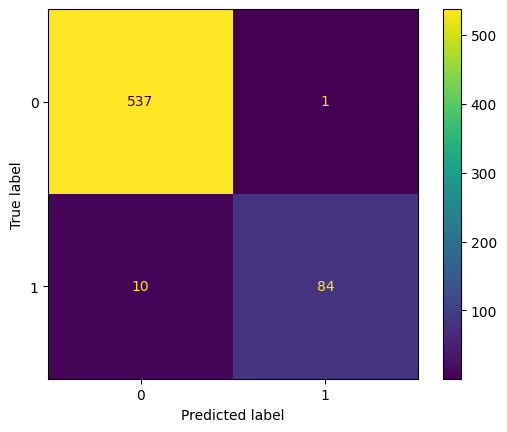

In [182]:
print (CatBoost_TF)
pred = CatBoost_TF.predict(X_tf_svd_test)
print ()
print (classification_report(y_test, pred))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, pred), display_labels=model.classes_)
disp.plot()

## Count Vectors

DecisionTreeClassifier(ccp_alpha=0.001, criterion='entropy', max_depth=12,
                       min_samples_leaf=3, random_state=42)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       538
           1       0.90      0.81      0.85        94

    accuracy                           0.96       632
   macro avg       0.94      0.90      0.91       632
weighted avg       0.96      0.96      0.96       632



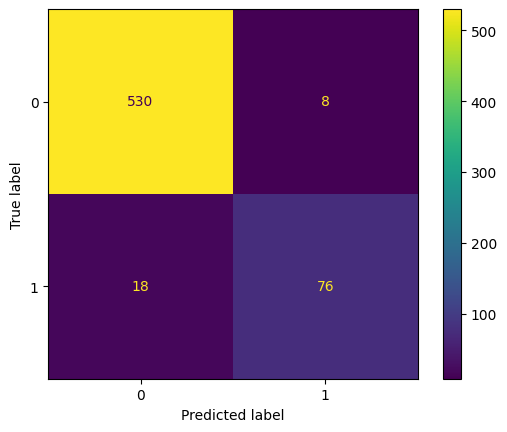

In [184]:
print_res(tree_CV, X_cv, X_cv_test)

LogisticRegression(C=1, random_state=42, solver='liblinear')

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       538
           1       1.00      0.96      0.98        94

    accuracy                           0.99       632
   macro avg       1.00      0.98      0.99       632
weighted avg       0.99      0.99      0.99       632



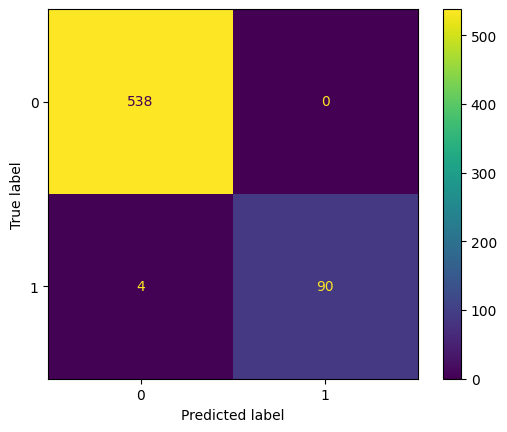

In [185]:
print_res(logit_CV, X_cv, X_cv_test)

GaussianNB(var_smoothing=1e-05)

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       538
           1       0.93      0.79      0.85        94

    accuracy                           0.96       632
   macro avg       0.94      0.89      0.91       632
weighted avg       0.96      0.96      0.96       632



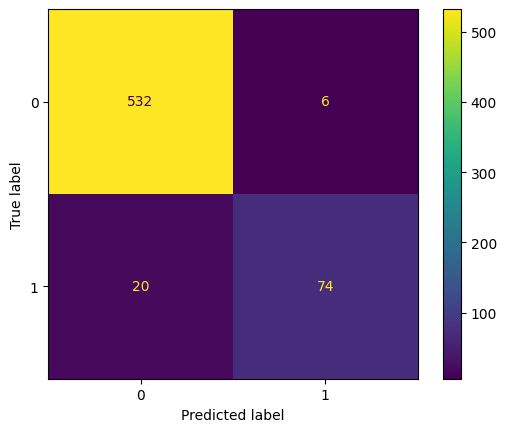

In [198]:
print_res(bayes_CV, X_cv.toarray(), X_cv_test.toarray())


              precision    recall  f1-score   support

           0       0.96      0.99      0.97       538
           1       0.91      0.77      0.83        94

    accuracy                           0.95       632
   macro avg       0.94      0.88      0.90       632
weighted avg       0.95      0.95      0.95       632



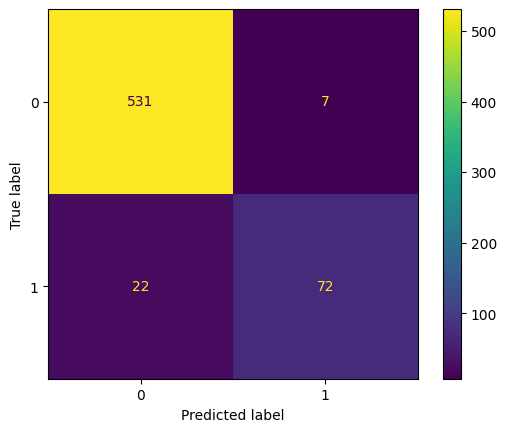

In [201]:
print (CatBoost_CV)
pred = CatBoost_CV.predict(X_cv_svd_test)
print ()
print (classification_report(y_test, pred))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, pred), display_labels=model.classes_)
disp.plot()

## Какой мы можем вывод при сравнении 8 обученных нами моделей.

В целом, каждая из моделей достаточно точная и имеет право на жизнь - они все справляются с задачей детекции спама на удобоваримом уровне.

Если говорить про оптимальную модель, то очевидно, что лучшую точность показывает два алгоритма - логистическая регрессия и catboost. Важно отметить, что потенциально catboost может показывать ещё более точные результаты, если реализовать подбор гиперпараметров. В зависимости от нашей задачи, можно подобрить оптимальный threshold для максимизации либо precision или recall

При этом несколько удивляют результаты при сравнении TF-IDF и Count Vectors. Так, для большинства моделей более высокую точность ожидаемо дает TF-IDF - так как этот подход к векторизации несет в себе больше информации, ведь учитывает не только частоту, но и важность слов (что подтверждается и при снижении размерности обработанных данных). Впрочем, для такой задачи, как идентификация спама, как раз таки именно частота некоторых ключевых слов и может быть одним из основных показателей.

Однако **на данной тестовой выборке логистическая регрессия на CV является лучшей моделью**. При этом CV также представляет интерес с точки зрения простоты своего сжатия в несколько компонент - ведь если мы представим, что мы работаем с очень большим датасетом, то возможность подобного сжатия крайне важна.

***Из смешного**: такой результат даже не очень удивителен и даже соотносится с практикой. Например, в X5 group для большинства NLP задач используется как раз таки комбинация из TF-IDF и логистической регрессии.* 